# Análisis exploratorio de los datos

In [1]:
# Importar librería para cargar datos procesados
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

In [2]:
# Para que no se desplieguen las advertencias
warnings.filterwarnings("ignore")

In [3]:
# Cargar los datos procesados
df = pd.read_parquet('../../data/processed/COVID19MEXICO_Processed.parquet')

# Inspeccionar las primeras filas de los datos procesados
df.head()

,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,INTUBADO,NEUMONIA,...,DEFUNCION,AÑO_ACTUALIZACION,MES_ACTUALIZACION,DIA_ACTUALIZACION,AÑO_INGRESO,MES_INGRESO,DIA_INGRESO,AÑO_SINTOMAS,MES_SINTOMAS,DIA_SINTOMAS
0,2,12,9,2,9,9,9,1,-2,2,...,2,2024,4,23,2023,2,26,2023,2,22
1,2,6,5,1,5,5,28,1,-2,2,...,2,2024,4,23,2023,3,24,2023,3,19
2,1,12,9,1,9,9,12,1,-2,2,...,2,2024,4,23,2023,3,2,2023,3,1
3,2,12,16,2,16,16,41,1,-2,2,...,2,2024,4,23,2023,3,9,2023,3,6
4,2,12,3,1,15,3,3,1,-2,2,...,2,2024,4,23,2023,6,12,2023,6,9


Crear Dataframe solo con pacientes COVID positivos

In [4]:
# Filtrar los datos para pacientes COVID positivos
df_covid = df[df['CLASIFICACION_FINAL'] == 1]

# Filtrar los datos para pacientes COVID fallecidos
df_defuncion = df_covid[df_covid['DEFUNCION'] == 1]

Crear constantes

In [5]:
# Lista de comorbilidades
COMORBILIDADES = ['NEUMONIA', 'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
       'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA']

# Número de pacientes fallecidos y no fallecidos
N_NO_FALLECIDOS = len(df[df['DEFUNCION'] == 2])
N_FALLECIDOS = len(df[df['DEFUNCION'] == 1])

# Número de pacientes COVID fallecidos y no fallecidos
N_COVID_NO_FALLECIDOS = len(df_covid[df_covid['DEFUNCION'] == 2]
                            )
N_COVID_FALLECIDOS = len(df_covid[df_covid['DEFUNCION'] == 1])

# Diccionario de entidades federativas
ENTIDADES = {
    1: 'Aguascalientes', 2: 'Baja California', 3: 'Baja California Sur', 4: 'Campeche',
    5: 'Coahuila de Zaragoza', 6: 'Colima', 7: 'Chiapas', 8: 'Chihuahua',
    9: 'Ciudad de México', 10: 'Durango', 11: 'Guanajuato', 12: 'Guerrero',
    13: 'Hidalgo', 14: 'Jalisco', 15: 'Edo. de México', 16: 'Michoacán de Ocampo',
    17: 'Morelos', 18: 'Nayarit', 19: 'Nuevo León', 20: 'Oaxaca',
    21: 'Puebla', 22: 'Querétaro', 23: 'Quintana Roo', 24: 'San Luis Potosí',
    25: 'Sinaloa', 26: 'Sonora', 27: 'Tabasco', 28: 'Tamaulipas',
    29: 'Tlaxcala', 30: 'Veracruz de Ignacio de la Llave', 31: 'Yucatán',
    32: 'Zacatecas'
}

### Geografía 

**¿Qué entidades presentan la mayor cantidad de casos COVID positivos?**

In [6]:
# Cargar el shapefile de estados/provincias de Natural Earth
gdf = gpd.read_file('ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp')

# Filtrar solo las entidades de México
gdf = gdf[gdf['admin'] == 'Mexico']

# Diccionario para remapear el nombre de algunos estados para que coincidan con nuestros datos
remap_entidades = {
    "Distrito Federal": "Ciudad de México",
    "Coahuila": "Coahuila de Zaragoza",
    "México": "Edo. de México",
    "Michoacán": "Michoacán de Ocampo",
    "Veracruz": "Veracruz de Ignacio de la Llave"
}

# Remapeo de nombres de estados
gdf["name"] = gdf["name"].map(remap_entidades).fillna(gdf["name"])


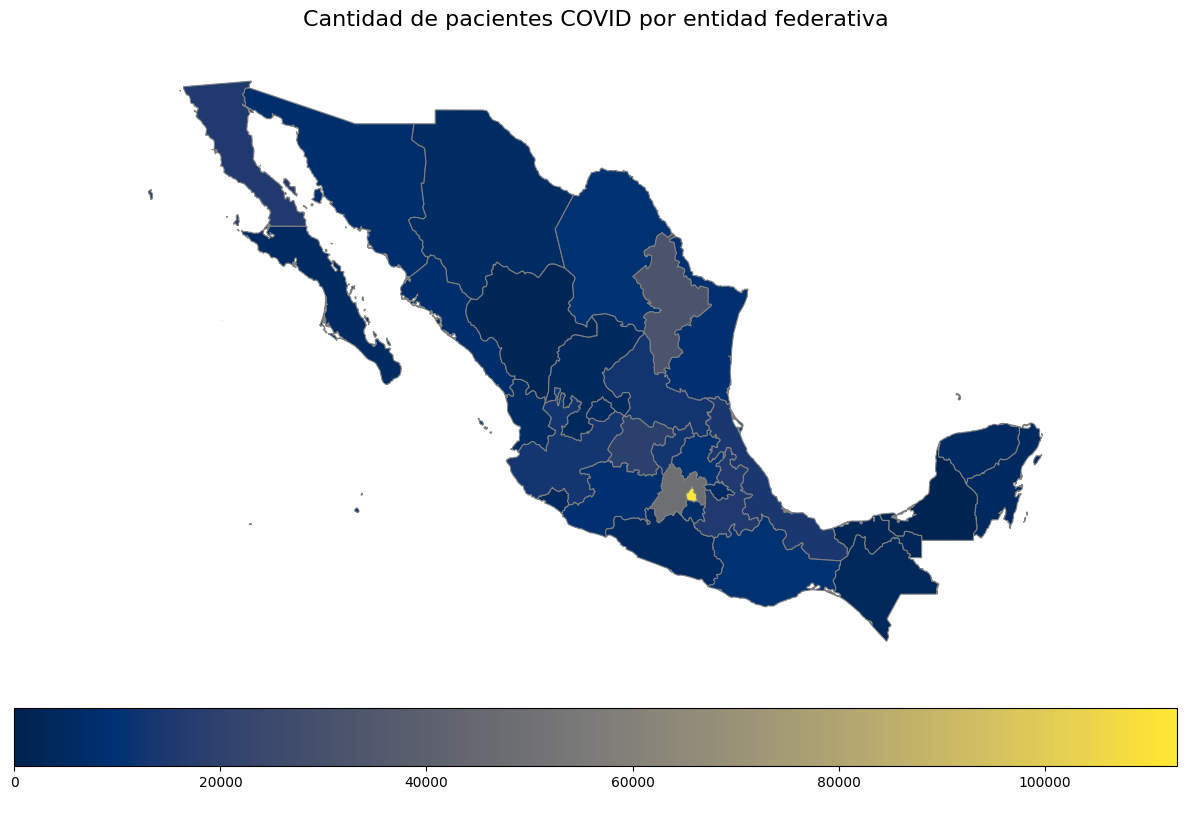

In [7]:
# Crear copía del dataframe
df_map = df_covid.copy()

# Convertir los valores de la columna 'ENTIDAD_RES' usando el diccionario
df_map['ENTIDAD_RES'] = df_map['ENTIDAD_RES'].map(ENTIDADES)

# Calcular el número de casos diagnosticados con COVID-19 por entidad federativa
casos_por_entidad = df_map['ENTIDAD_RES'].value_counts().reset_index()
casos_por_entidad.columns = ['ENTIDAD_RES', 'Casos']

# Combinar los datos de casos con el GeoDataFrame de México
gdf_casos = gdf.merge(casos_por_entidad, left_on='name', right_on='ENTIDAD_RES', how='left').fillna(0)

# Crear la figura
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Mapa de casos diagnosticados
gdf_casos.plot(column='Casos', cmap='cividis', linewidth=0.8, ax=ax, edgecolor='0.5', legend=True, legend_kwds={'label': " ", 'location': 'bottom', 'pad': 0.05})
ax.set_title('Cantidad de pacientes COVID por entidad federativa', fontsize=16, pad=20)
ax.axis('off')

# Mostrar la figura
plt.show()

**¿Los estados que tienen más casos de COVID son también los que tienen más defunciones?**

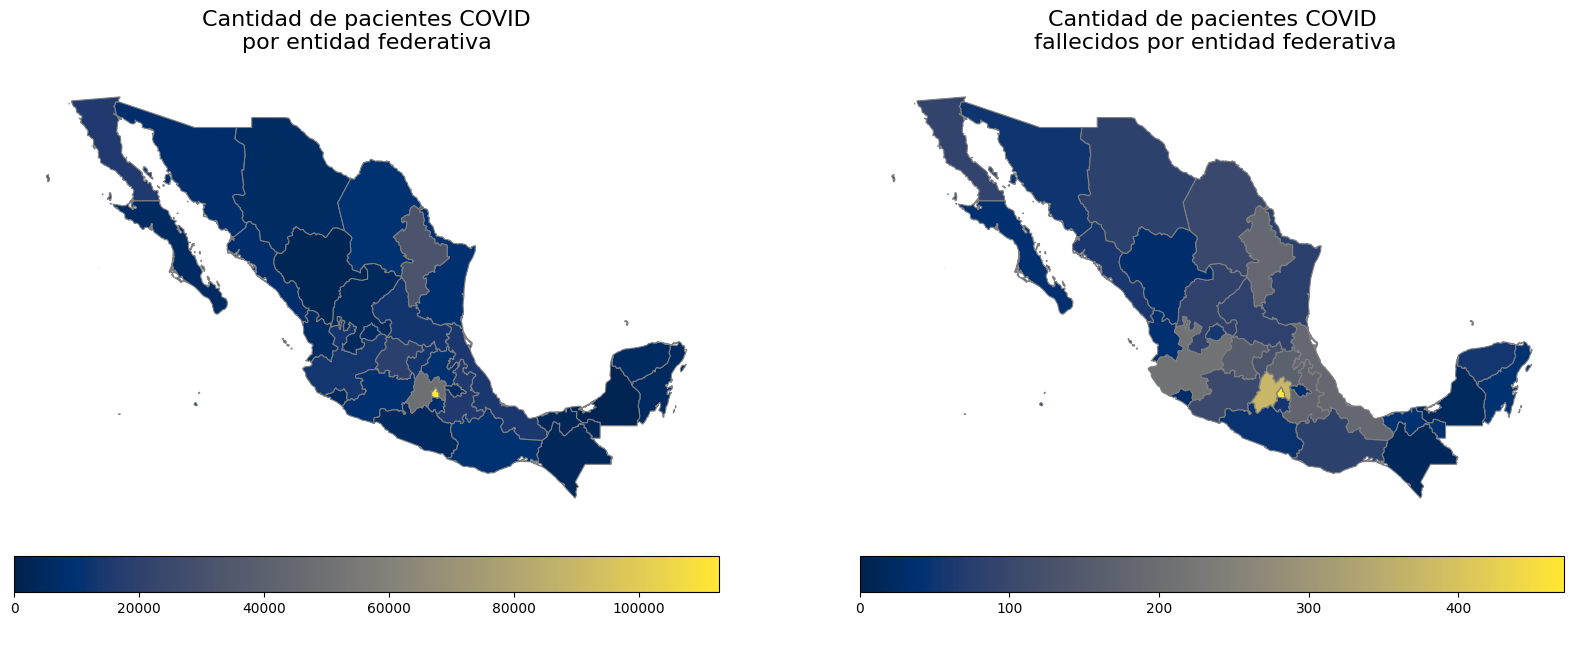

In [8]:
# Calcular el número de defunciones por entidad federativa
defunciones_por_entidad = df_map[df_map['DEFUNCION'] == 1]['ENTIDAD_RES'].value_counts().reset_index()
defunciones_por_entidad.columns = ['ENTIDAD_RES', 'Defunciones']

# Combinar los datos de defunciones con el GeoDataFrame de México
gdf_defunciones = gdf.merge(defunciones_por_entidad, left_on='name', right_on='ENTIDAD_RES', how='left').fillna(0)

# Crear la figura y los ejes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Mapa de casos diagnosticados
gdf_casos.plot(column='Casos', cmap='cividis', linewidth=0.8, ax=ax1, edgecolor='0.5', legend=True, legend_kwds={'label': " ", 'location': 'bottom', 'pad': 0.05})
ax1.set_title('Cantidad de pacientes COVID\npor entidad federativa', fontsize=16, pad=20)
ax1.axis('off')

# Mapa de defunciones
gdf_defunciones.plot(column='Defunciones', cmap='cividis', linewidth=0.8, ax=ax2, edgecolor='0.5', legend=True, legend_kwds={'label': " ", 'location': 'bottom', 'pad': 0.05})
ax2.set_title('Cantidad de pacientes COVID\n fallecidos por entidad federativa', fontsize=16, pad=20)
ax2.axis('off')

# Mostrar la figura
plt.show()

Notamos que los estados de Jalisco e Hidalgo, a pesar de no haber presentado tantos casos confirmados de COVID como otros estados, son de las entidades con mayor número de fallecidos. 

**En las entidades con más defunciones, ¿cuáles fueron los municipios más afectados?**

Importamos el catálogo de municipios

In [9]:
# Cargar el catálogo de municipios desde la hoja correcta
file_path = '../../references/processed/Catalogos.xlsx'
catalogo_municipios = pd.read_excel(file_path, sheet_name='Catálogo MUNICIPIOS')

# Mostrar las primeras filas del catálogo para entender su estructura
catalogo_municipios.head()

,CLAVE_MUNICIPIO,MUNICIPIO,CLAVE_ENTIDAD
0,1,AGUASCALIENTES,1
1,2,ASIENTOS,1
2,3,CALVILLO,1
3,4,COSÍO,1
4,5,JESÚS MARÍA,1


Identificamos a las 3 entidades con más defunciones

In [10]:
# Extraer entidades con más defunciones
entidades_top_3 = defunciones_por_entidad['ENTIDAD_RES'][:3].to_list()

# Imprimimos el resultado
entidades_top_3

['Ciudad de México', 'Edo. de México', 'Jalisco']

In [11]:
# Crear copia de dataframe
df_municipio = df_defuncion.copy()

# Filtrar los datos de CDMX, Edo. de México y Jalisco
df_fallecidos_cdmx = df_municipio[df_municipio['ENTIDAD_RES'] == 9]
df_fallecidos_edomx = df_municipio[df_municipio['ENTIDAD_RES'] == 15]
df_fallecidos_jal = df_municipio[df_municipio['ENTIDAD_RES'] == 14]

# Calcular el número de fallecidos por municipio en CDMX, Edo. de México y Jalisco
fallecidos_cdmx_municipio = df_fallecidos_cdmx['MUNICIPIO_RES'].value_counts().reset_index()
fallecidos_cdmx_municipio.columns = ['CLAVE_MUNICIPIO', 'Defunciones']

fallecidos_edomx_municipio = df_fallecidos_edomx['MUNICIPIO_RES'].value_counts().reset_index()
fallecidos_edomx_municipio.columns = ['CLAVE_MUNICIPIO', 'Defunciones']

fallecidos_jal_municipio = df_fallecidos_jal['MUNICIPIO_RES'].value_counts().reset_index()
fallecidos_jal_municipio.columns = ['CLAVE_MUNICIPIO', 'Defunciones']

# Filtrar los catálogos de municipios para CDMX, Edo. de México y Jalisco
catalogo_cdmx = catalogo_municipios[catalogo_municipios['CLAVE_ENTIDAD'] == 9]
catalogo_edomx = catalogo_municipios[catalogo_municipios['CLAVE_ENTIDAD'] == 15]
catalogo_jal = catalogo_municipios[catalogo_municipios['CLAVE_ENTIDAD'] == 14]

# Combinar los datos de defunciones con los catálogos de municipios
fallecidos_cdmx = fallecidos_cdmx_municipio.merge(catalogo_cdmx, left_on='CLAVE_MUNICIPIO', right_on='CLAVE_MUNICIPIO')
fallecidos_edomx = fallecidos_edomx_municipio.merge(catalogo_edomx, left_on='CLAVE_MUNICIPIO', right_on='CLAVE_MUNICIPIO')
fallecidos_jal = fallecidos_jal_municipio.merge(catalogo_jal, left_on='CLAVE_MUNICIPIO', right_on='CLAVE_MUNICIPIO')

# Ordenar los datos de mayor a menor
fallecidos_cdmx = fallecidos_cdmx.sort_values(by='Defunciones', ascending=False)
fallecidos_edomx = fallecidos_edomx.sort_values(by='Defunciones', ascending=False)
fallecidos_jal = fallecidos_jal.sort_values(by='Defunciones', ascending=False)

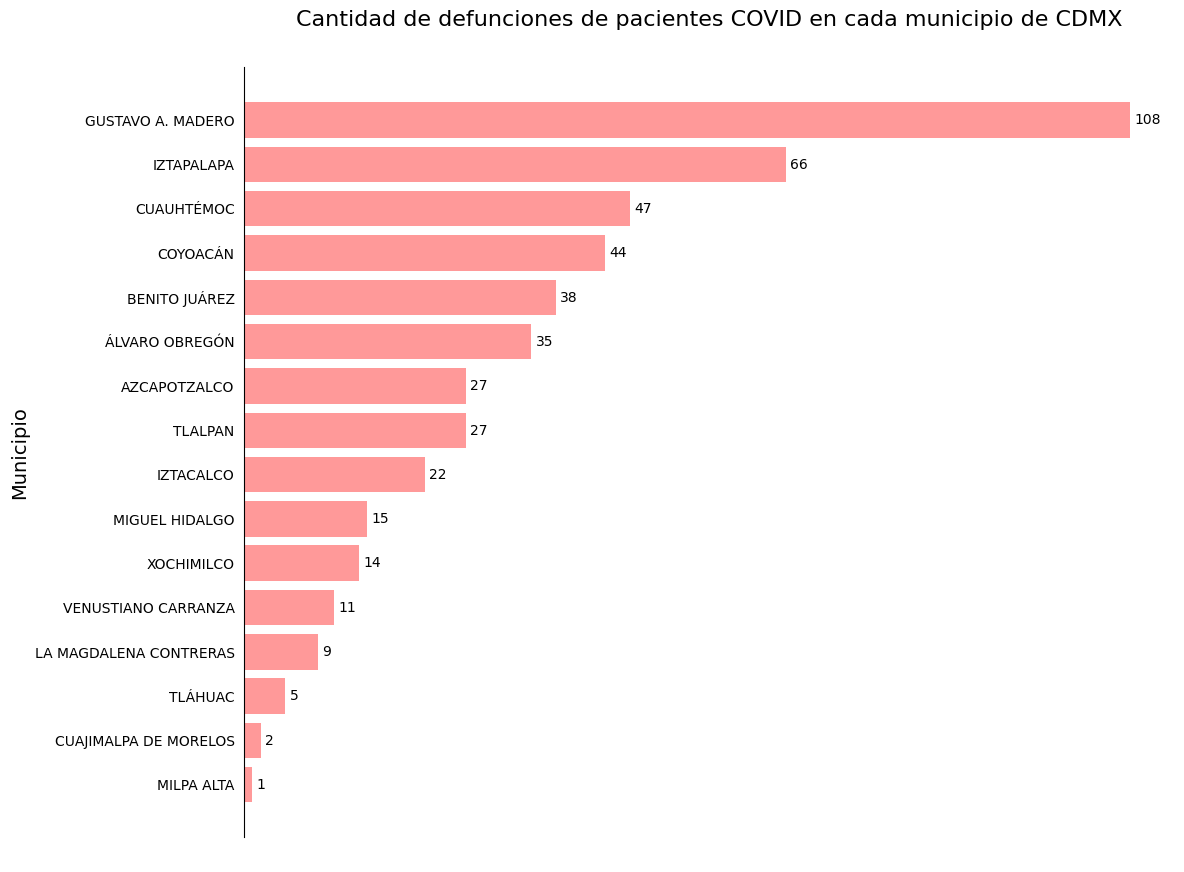

In [12]:
# Crear gráficos de barras horizontales
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Gráfico para Jalisco
bars = ax.barh(fallecidos_cdmx['MUNICIPIO'], fallecidos_cdmx['Defunciones'], color='#ff9999')
ax.set_title('Cantidad de defunciones de pacientes COVID en cada municipio de CDMX', fontsize=16, pad=30)
ax.set_xlabel(' ', fontsize=14)
ax.set_ylabel('Municipio', fontsize=14)
ax.invert_yaxis()  # Invertir el eje y para que las barras más grandes estén arriba

# Desactivar las marcas en el eje x
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# Desactivar las marcas en el eje y
ax.tick_params(axis='y', which='both', left=False)

# Mantener solo el borde izquierdo
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Añadir el número de defunciones encima de cada barra
for bar in bars:
    width = bar.get_width()
    ax.annotate(f'{width}',
                xy=(width, bar.get_y() + bar.get_height() / 2),
                xytext=(3, 0),  # 3 points horizontal offset
                textcoords="offset points",
                ha='left', va='center')

# Mostrar la figura
plt.show()

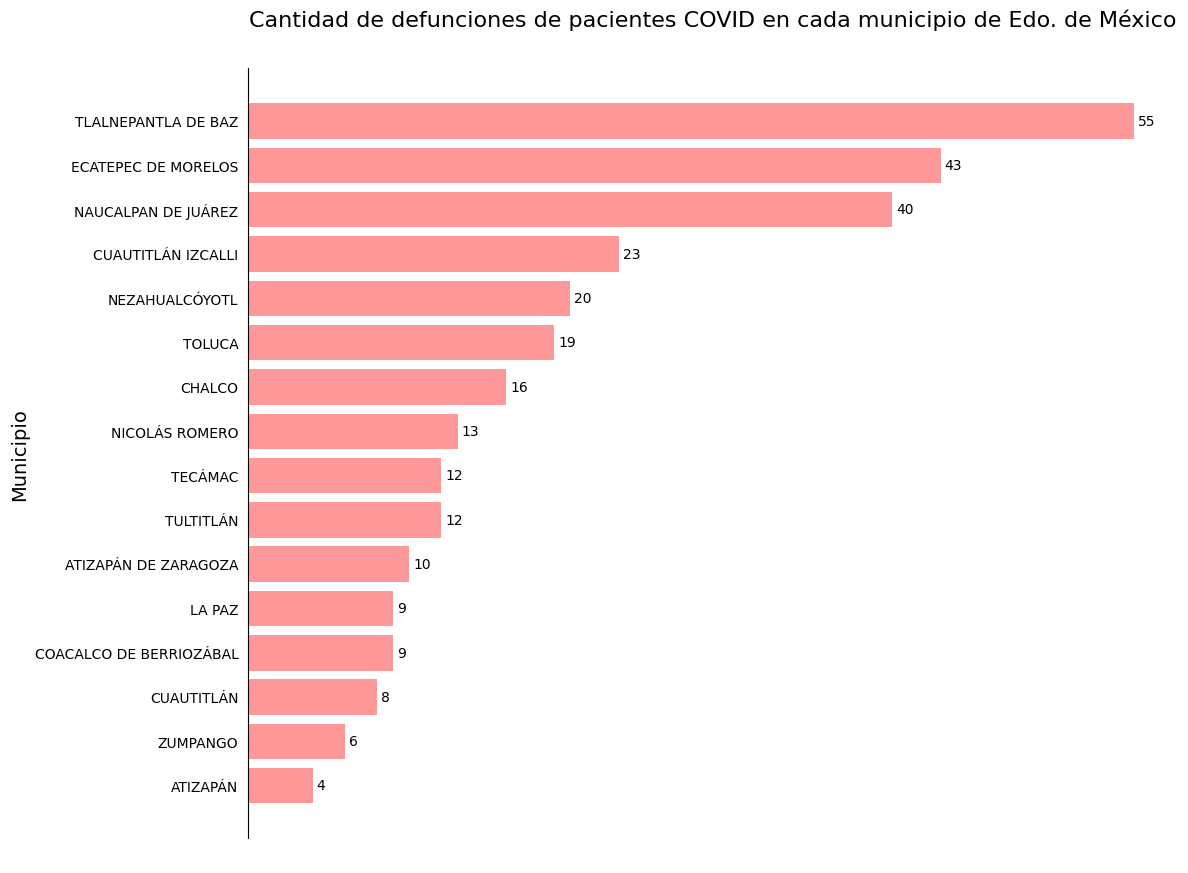

In [13]:
# Crear gráficos de barras horizontales
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Gráfico para Jalisco
bars = ax.barh(fallecidos_edomx['MUNICIPIO'][:16], fallecidos_edomx['Defunciones'][:16], color='#ff9999')
ax.set_title('Cantidad de defunciones de pacientes COVID en cada municipio de Edo. de México', fontsize=16, pad=30)
ax.set_xlabel(' ', fontsize=14)
ax.set_ylabel('Municipio', fontsize=14)
ax.invert_yaxis()  # Invertir el eje y para que las barras más grandes estén arriba

# Desactivar las marcas en el eje x
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# Desactivar las marcas en el eje y
ax.tick_params(axis='y', which='both', left=False)

# Mantener solo el borde izquierdo
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Añadir el número de defunciones encima de cada barra
for bar in bars:
    width = bar.get_width()
    ax.annotate(f'{width}',
                xy=(width, bar.get_y() + bar.get_height() / 2),
                xytext=(3, 0),  # 3 points horizontal offset
                textcoords="offset points",
                ha='left', va='center')

# Mostrar la figura
plt.show()

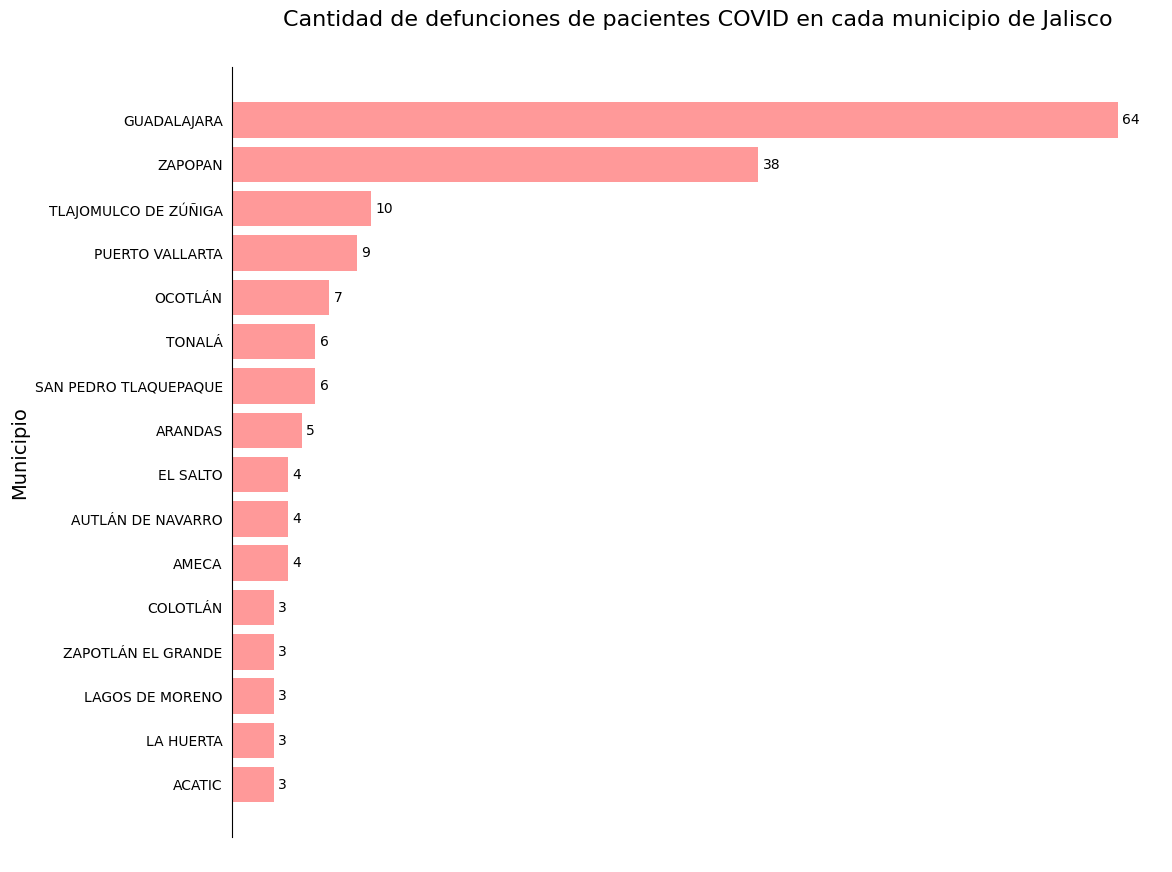

In [14]:
# Crear gráficos de barras horizontales
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Gráfico para Jalisco
bars = ax.barh(fallecidos_jal['MUNICIPIO'][:16], fallecidos_jal['Defunciones'][:16], color='#ff9999')
ax.set_title('Cantidad de defunciones de pacientes COVID en cada municipio de Jalisco', fontsize=16, pad=30)
ax.set_xlabel(' ', fontsize=14)
ax.set_ylabel('Municipio', fontsize=14)
ax.invert_yaxis()  # Invertir el eje y para que las barras más grandes estén arriba

# Desactivar las marcas en el eje x
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# Desactivar las marcas en el eje y
ax.tick_params(axis='y', which='both', left=False)

# Mantener solo el borde izquierdo
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Añadir el número de defunciones encima de cada barra
for bar in bars:
    width = bar.get_width()
    ax.annotate(f'{width}',
                xy=(width, bar.get_y() + bar.get_height() / 2),
                xytext=(3, 0),  # 3 points horizontal offset
                textcoords="offset points",
                ha='left', va='center')

# Mostrar la figura
plt.show()

Este análisis nos permite hacernos una idea de la relevancia que tiene no solo la entidad, sino el municipio específico en el que se encuentra la persona al ser diagnósticaga con COVID para determinar sus probabilidades de defunción. 

### Demografía

**¿Cómo influye la edad de los pacientes COVID positivos en el porcentaje de fallecimiento?**

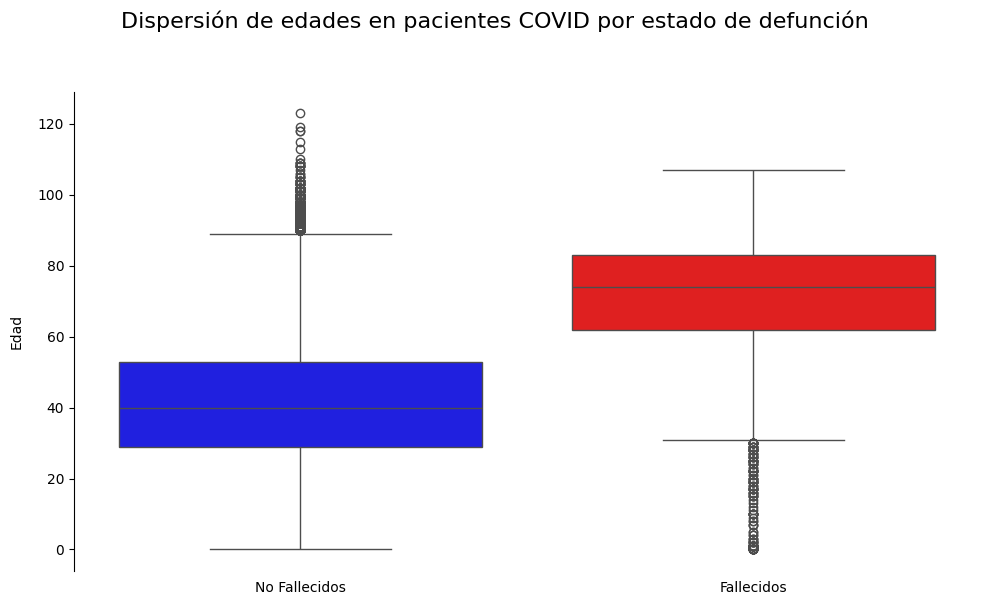

In [15]:
# Separar los datos en fallecidos y no fallecidos
fallecidos = df_covid[df_covid['DEFUNCION'] == 1]
no_fallecidos = df_covid[df_covid['DEFUNCION'] == 2]

# Crear un DataFrame para facilitar la creación de los boxplots
data = pd.DataFrame({
    'Edad': df_covid['EDAD'],
    'Estado': ['Fallecidos' if x == 1 else 'No Fallecidos' for x in df_covid['DEFUNCION']]
})

# Crear boxplots para ambas distribuciones
fig, ax = plt.subplots(figsize=(10, 6))

# Título superior de la figura
fig.suptitle('Dispersión de edades en pacientes COVID por estado de defunción', fontsize=16, y=1.00)

# Crear boxplot
sns.boxplot(x='Estado', y='Edad', data=data, ax=ax, palette={'Fallecidos': 'red', 'No Fallecidos': 'blue'})

# Títulos y etiquetas
ax.set_xlabel('', labelpad=15)
ax.set_ylabel('Edad', labelpad=10)

# Desactivar las marcas en el eje x
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
# Desactivar las marcas en el eje y
#ax.tick_params(axis='y', which='both', left=False)

# Mantener solo el borde izquierdo
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

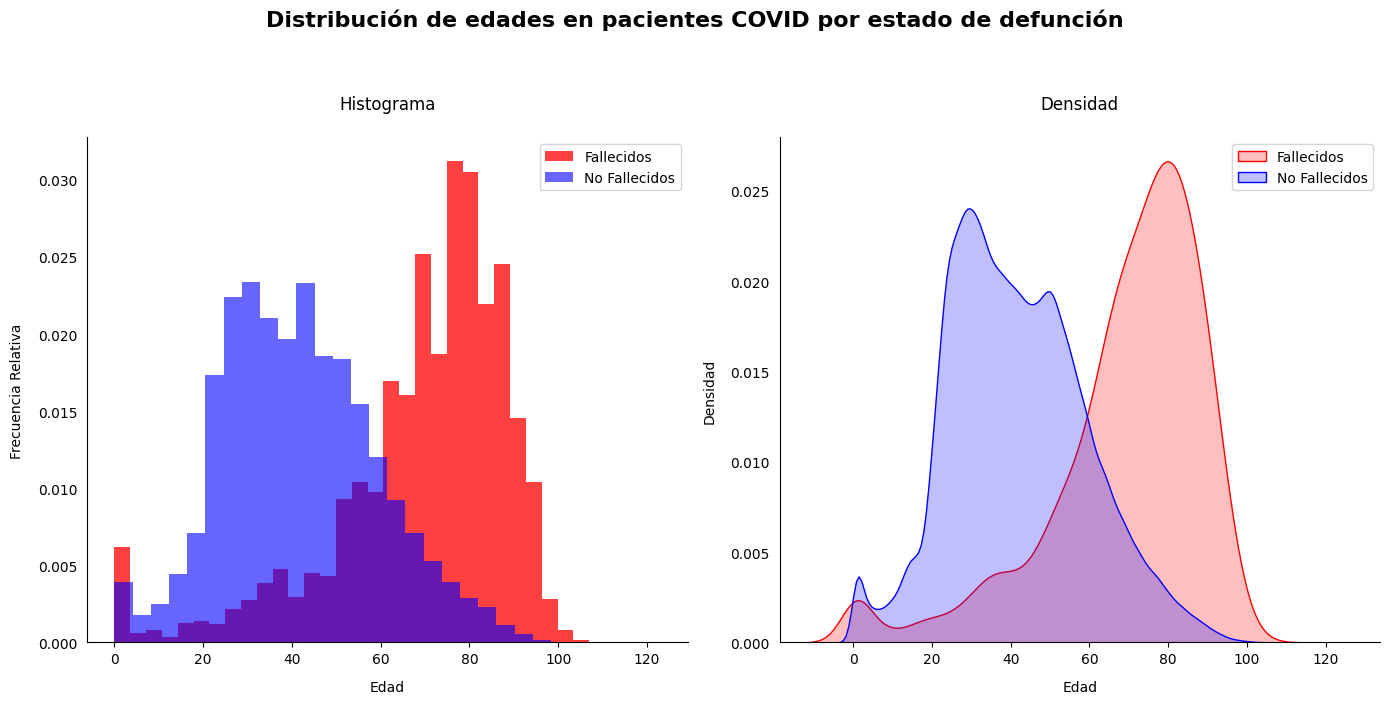

In [16]:

# Separar los datos en fallecidos y no fallecidos
fallecidos = df_covid[df_covid['DEFUNCION'] == 1]
no_fallecidos = df_covid[df_covid['DEFUNCION'] == 2]

# Crear histogramas de frecuencia relativa y gráficos de densidad para ambas distribuciones
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Título superior de la figura
fig.suptitle('Distribución de edades en pacientes COVID por estado de defunción', fontsize=16, y=1.00, fontweight='bold')

# Histograma de frecuencia relativa sin edges
sns.histplot(fallecidos['EDAD'], color='red', kde=False, label='Fallecidos', bins=30, stat='density', edgecolor=None, ax=ax1)
sns.histplot(no_fallecidos['EDAD'], color='blue', kde=False, label='No Fallecidos', bins=30, stat='density', alpha=0.6, edgecolor=None, ax=ax1)
ax1.set_title('Histograma', pad=20)
ax1.set_xlabel('Edad', labelpad=10)
ax1.set_ylabel('Frecuencia Relativa', labelpad=10)
ax1.legend()

# Desactivar las marcas en el eje x
#ax1.tick_params(axis='x', which='both', bottom=False)
# Desactivar las marcas en el eje y
ax1.tick_params(axis='y', which='both', left=False)

# Mantener solo el borde izquierdo
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_visible(True)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Gráfico de Densidad
sns.kdeplot(fallecidos['EDAD'], color='red', label='Fallecidos', shade=True, ax=ax2)
sns.kdeplot(no_fallecidos['EDAD'], color='blue', label='No Fallecidos', shade=True, ax=ax2)
ax2.set_title('Densidad', pad=20)
ax2.set_xlabel('Edad', labelpad=10)
ax2.set_ylabel('Densidad', labelpad=10)
ax2.legend()

# Desactivar las marcas en el eje x
#ax2.tick_params(axis='x', which='both', bottom=False)
# Desactivar las marcas en el eje y
ax2.tick_params(axis='y', which='both', left=False)

# Mantener solo el borde izquierdo
ax2.spines['left'].set_visible(True)
ax2.spines['bottom'].set_visible(True)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

**¿Cómo influye el sexo de los pacientes COVID positivos en el porcentaje de fallecimiento?**

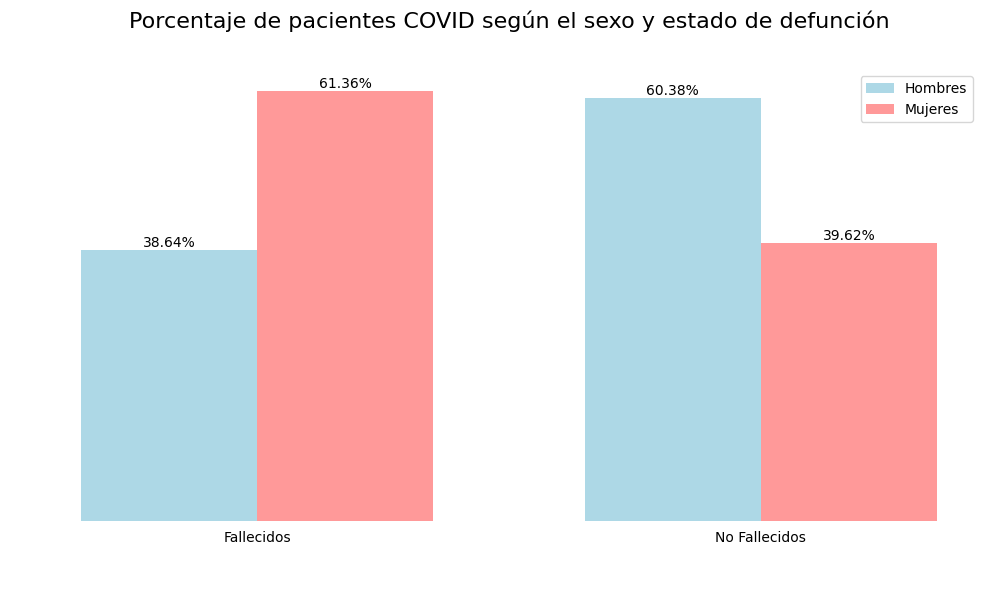

In [17]:
# Calcular el porcentaje de personas fallecidas y no fallecidas por sexo
fallecidos_hombres = len(df_covid[(df_covid['DEFUNCION'] == 1) & (df_covid['SEXO'] == 1)])
fallecidos_mujeres = len(df_covid[(df_covid['DEFUNCION'] == 1) & (df_covid['SEXO'] == 2)])
no_fallecidos_hombres = len(df_covid[(df_covid['DEFUNCION'] == 2) & (df_covid['SEXO'] == 1)])
no_fallecidos_mujeres = len(df_covid[(df_covid['DEFUNCION'] == 2) & (df_covid['SEXO'] == 2)])

# Porcentajes
porcentaje_fallecidos_hombres = fallecidos_hombres / N_COVID_FALLECIDOS * 100
porcentaje_fallecidos_mujeres = fallecidos_mujeres / N_COVID_FALLECIDOS * 100
porcentaje_no_fallecidos_hombres = no_fallecidos_hombres / N_COVID_NO_FALLECIDOS * 100
porcentaje_no_fallecidos_mujeres = no_fallecidos_mujeres / N_COVID_NO_FALLECIDOS * 100

# Datos para la gráfica
labels = ['Fallecidos', 'No Fallecidos']
hombres = [porcentaje_fallecidos_hombres, porcentaje_no_fallecidos_hombres]
mujeres = [porcentaje_fallecidos_mujeres, porcentaje_no_fallecidos_mujeres]

x = range(len(labels))

# Crear la gráfica de barras
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
bar1 = ax.bar(x, hombres, bar_width, label='Hombres', color='#add8e6')
bar2 = ax.bar([p + bar_width for p in x], mujeres, bar_width, label='Mujeres', color='#ff9999')

# Añadir los porcentajes encima de cada barra
for rect in bar1:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.2f}%', ha='center', va='bottom')
for rect in bar2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.2f}%', ha='center', va='bottom')

# Añadir títulos y etiquetas
ax.set_xlabel(' ', labelpad=15)
ax.set_ylabel(' ', labelpad=10)
ax.set_title('Porcentaje de pacientes COVID según el sexo y estado de defunción', pad=30, fontsize=16)
ax.set_xticks([p + bar_width / 2 for p in x])
ax.set_xticklabels(labels)
ax.legend()

# Desactivar las marcas en el eje x
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
# Desactivar las marcas en el eje y
ax.tick_params(axis='y', which='both', left=False, labelleft=False)

# Mantener solo el borde izquierdo
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

**¿Cómo influye ser indígena o hablar una lengua indígena en el porcentaje de fallecimientos de pacientes COVID positivos?**

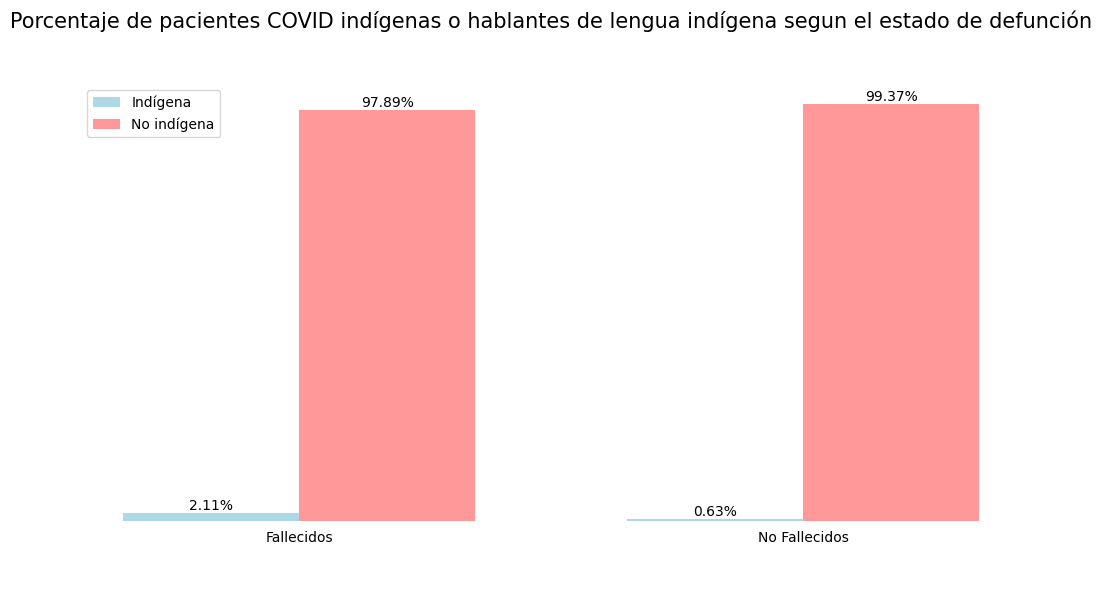

In [18]:
# Copia de nuestro dataframe con pacientes COVID positivos
covid_positivos = df_covid.copy()

# Crear una nueva columna 'CATEGORIA' para identificar si el paciente es indígena o no
covid_positivos['CATEGORIA'] = covid_positivos.apply(lambda row: 'Indígena' if row['HABLA_LENGUA_INDIG'] == 1 or row['INDIGENA'] == 1 else 'No indígena', axis=1)


# Calcular el porcentaje de personas fallecidas y no fallecidas por categoría
fallecidos_indigena = len(covid_positivos[(covid_positivos['DEFUNCION'] == 1) & (covid_positivos['CATEGORIA'] == 'Indígena')])
fallecidos_no_indigena = len(covid_positivos[(covid_positivos['DEFUNCION'] == 1) & (covid_positivos['CATEGORIA'] == 'No indígena')])
no_fallecidos_indigena = len(covid_positivos[(covid_positivos['DEFUNCION'] == 2) & (covid_positivos['CATEGORIA'] == 'Indígena')])
no_fallecidos_no_indigena = len(covid_positivos[(covid_positivos['DEFUNCION'] == 2) & (covid_positivos['CATEGORIA'] == 'No indígena')])

# Porcentajes
porcentaje_fallecidos_indigena = fallecidos_indigena / N_COVID_FALLECIDOS * 100
porcentaje_fallecidos_no_indigena = fallecidos_no_indigena / N_COVID_FALLECIDOS * 100
porcentaje_no_fallecidos_indigena = no_fallecidos_indigena / N_COVID_NO_FALLECIDOS * 100
porcentaje_no_fallecidos_no_indigena = no_fallecidos_no_indigena / N_COVID_NO_FALLECIDOS * 100

# Datos para la gráfica
labels = ['Fallecidos', 'No Fallecidos']
indigena = [porcentaje_fallecidos_indigena, porcentaje_no_fallecidos_indigena]
no_indigena = [porcentaje_fallecidos_no_indigena, porcentaje_no_fallecidos_no_indigena]

x = range(len(labels))

# Crear la gráfica de barras
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
bar1 = ax.bar(x, indigena, bar_width, label='Indígena', color='#add8e6')
bar2 = ax.bar([p + bar_width for p in x], no_indigena, bar_width, label='No indígena', color='#ff9999')

# Añadir los porcentajes encima de cada barra
for rect in bar1:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.2f}%', ha='center', va='bottom')
for rect in bar2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.2f}%', ha='center', va='bottom')

# Añadir títulos y etiquetas
ax.set_xlabel(' ', labelpad=15)
ax.set_ylabel(' ', labelpad=10)
ax.set_title('Porcentaje de pacientes COVID indígenas o hablantes de lengua indígena segun el estado de defunción', pad=40,  fontsize=15)
ax.set_xticks([p + bar_width / 2 for p in x])
ax.set_xticklabels(labels)
ax.legend()

# Desactivar las marcas en el eje x
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
# Desactivar las marcas en el eje y
ax.tick_params(axis='y', which='both', left=False, labelleft=False)

# Mantener solo el borde izquierdo
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### Vicios y comorbilidades

**¿Qué porcentaje de los pacientes COVID positivos que fallecieron y no fallecieron presentaron tabaquismo?**

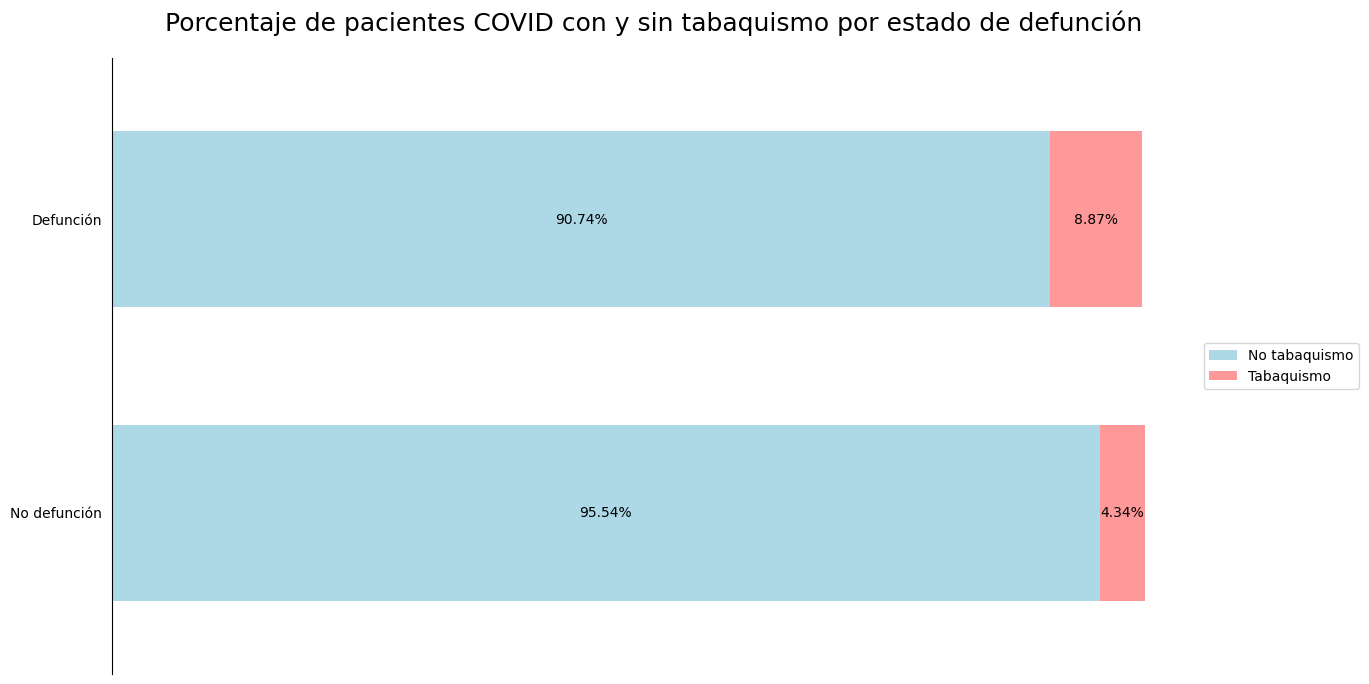

In [19]:
# Proporción de pacientes con y sin tabaquismo que no fallecieron
prop_no_fall_tabaquismo = len(df_covid[(df_covid['DEFUNCION'] == 2) & (df_covid['TABAQUISMO'] == 1)]) / N_COVID_NO_FALLECIDOS
prop_no_fall_no_tabaquismo = len(df_covid[(df_covid['DEFUNCION'] == 2) & (df_covid['TABAQUISMO'] == 2)]) / N_COVID_NO_FALLECIDOS

# Proporción de pacientes con y sin tabaquismo que fallecieron
prop_fall_tabaquismo = len(df_covid[(df_covid['DEFUNCION'] == 1) & (df_covid['TABAQUISMO'] == 1)]) / N_COVID_FALLECIDOS
prop_fall_no_tabaquismo = len(df_covid[(df_covid['DEFUNCION'] == 1) & (df_covid['TABAQUISMO'] == 2)]) / N_COVID_FALLECIDOS

# Preparar los datos para la gráfica
data = {
    'Estado': ['No defunción', 'Defunción'],
    'No tabaquismo': [prop_no_fall_no_tabaquismo, prop_fall_no_tabaquismo],
    'Tabaquismo': [prop_no_fall_tabaquismo, prop_fall_tabaquismo]
}

df_plot = pd.DataFrame(data)

# Crear la gráfica con seaborn
fig, ax = plt.subplots(figsize=(14, 8))  # Incrementar el tamaño de la gráfica
df_plot.set_index('Estado').plot(kind='barh', stacked=True, color=['#add8e6', '#ff9999'], width=0.6, ax=ax)

# Añadir algunas etiquetas, título y etiquetas de ejes personalizadas
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Porcentaje de pacientes COVID con y sin tabaquismo por estado de defunción', pad=20, fontsize=18)
ax.legend(labels=['No tabaquismo', 'Tabaquismo'], title='', loc='center left', bbox_to_anchor=(1, 0.5))  # Ubicar la leyenda fuera del gráfico

# Añadir etiquetas de datos sobre cada barra
for i, (no_tabaquismo, tabaquismo) in enumerate(zip(df_plot['No tabaquismo'], df_plot['Tabaquismo'])):
    ax.text(no_tabaquismo / 2, i, f'{no_tabaquismo:.2%}', ha='center', va='center', color='black')
    ax.text(no_tabaquismo + tabaquismo / 2, i, f'{tabaquismo:.2%}', ha='center', va='center', color='black')

# Desactivar las marcas en el eje x
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# Desactivar las marcas en el eje y
ax.tick_params(axis='y', which='both', left=False)

# Mantener solo el borde izquierdo
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

**¿Qué porcentaje de los pacientes COVID positivos que fallecieron y no fallecieron presentaron alguna comorbilidad?**

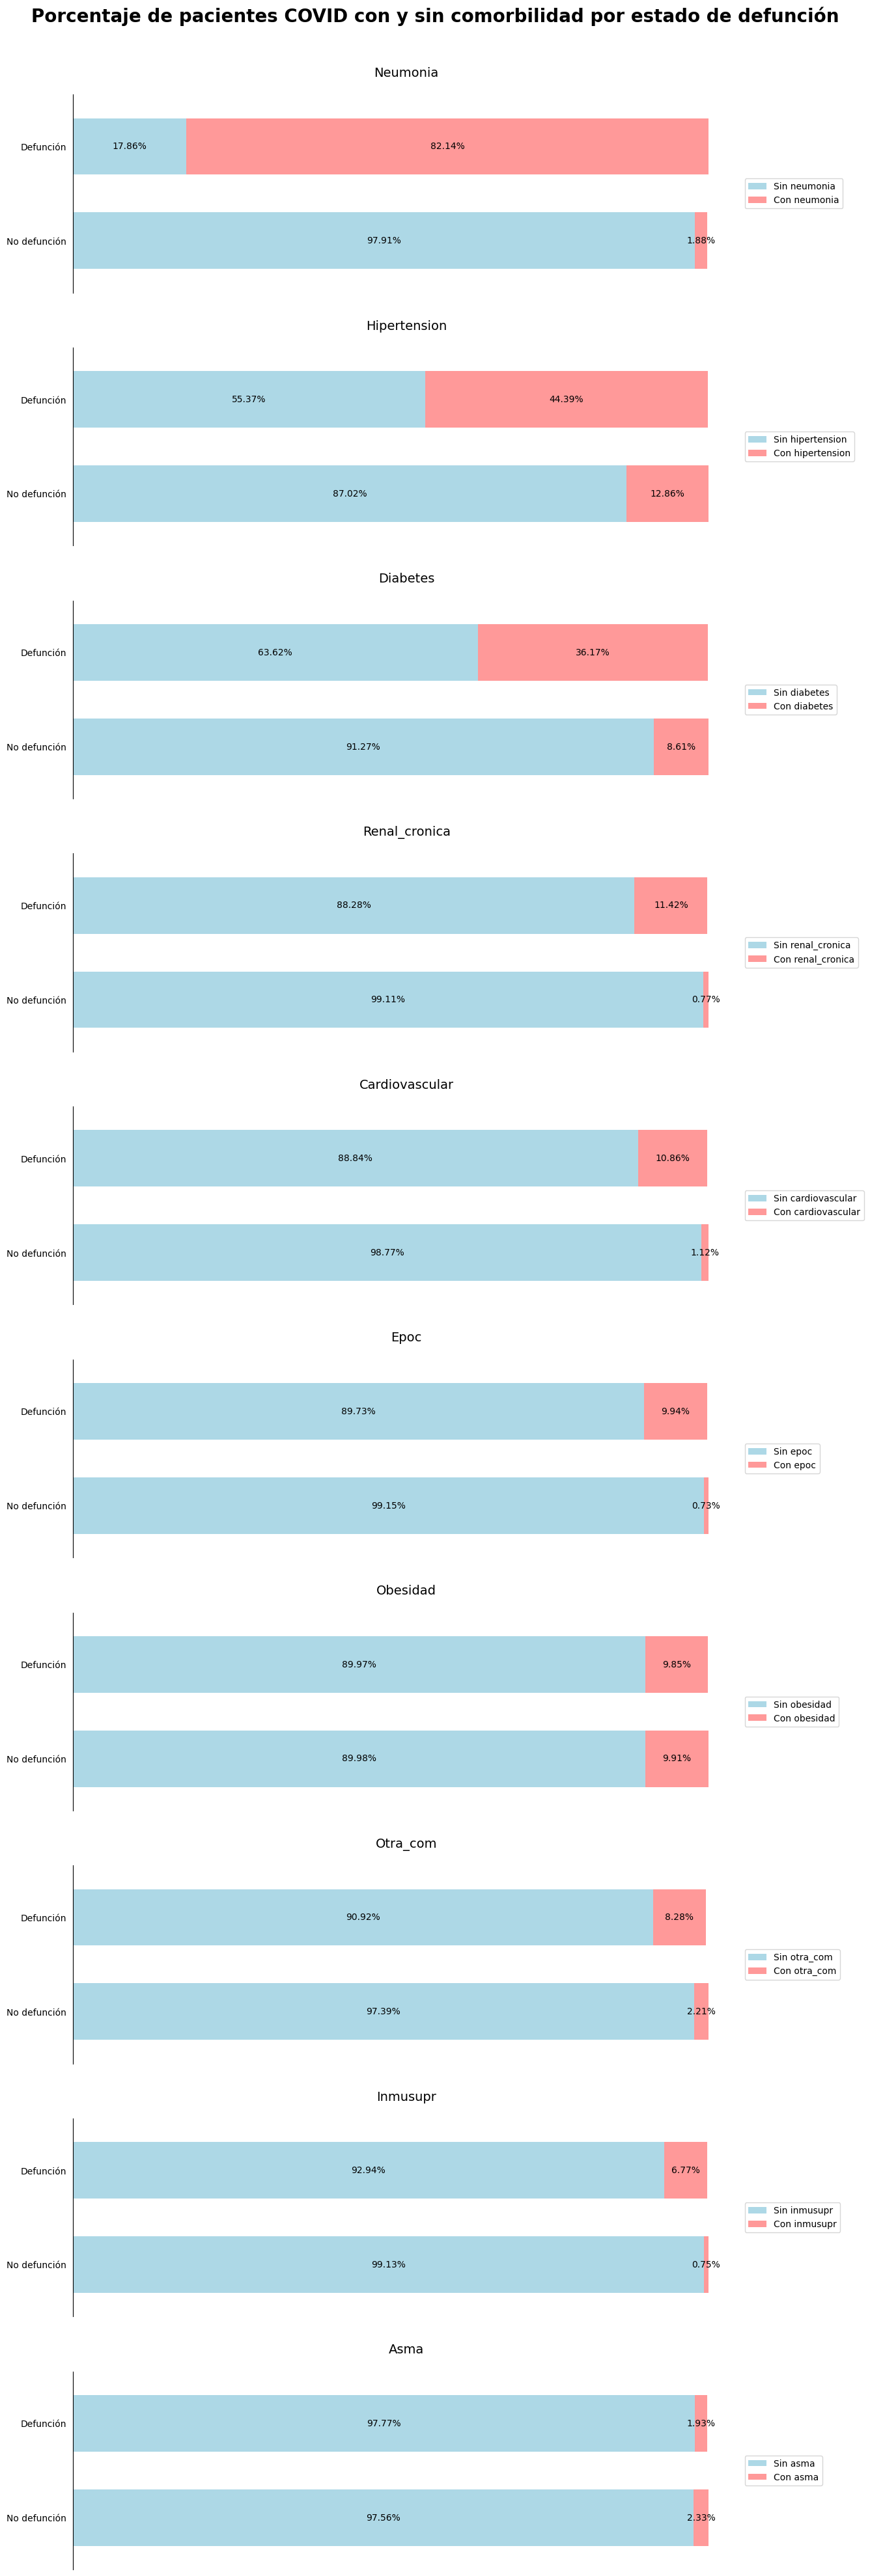

In [20]:
# Calcular los valores de defunción con comorbilidad para ordenar
defuncion_con_valores = {}
for var in COMORBILIDADES:
    prop_fall_con = len(df_covid[(df_covid['DEFUNCION'] == 1) & (df_covid[var] == 1)]) / N_COVID_FALLECIDOS
    defuncion_con_valores[var] = prop_fall_con

# Ordenar las variables en base a los valores calculados
variables_ordenadas = sorted(defuncion_con_valores, key=defuncion_con_valores.get, reverse=True)

# Crear figura y subgráficas
fig, axs = plt.subplots(nrows=len(COMORBILIDADES), ncols=1, figsize=(14, 4 * len(COMORBILIDADES)))
fig.suptitle('Porcentaje de pacientes COVID con y sin comorbilidad por estado de defunción', fontsize=20, fontweight="bold", y=0.995)

for i, var in enumerate(variables_ordenadas):
    # Calcular las proporciones por grupo
    prop_no_fall_con = len(df_covid[(df_covid['DEFUNCION'] == 2) & (df_covid[var] == 1)]) / N_COVID_NO_FALLECIDOS
    prop_no_fall_sin = len(df_covid[(df_covid['DEFUNCION'] == 2) & (df_covid[var] == 2)]) / N_COVID_NO_FALLECIDOS

    prop_fall_con = len(df_covid[(df_covid['DEFUNCION'] == 1) & (df_covid[var] == 1)]) / N_COVID_FALLECIDOS
    prop_fall_sin = len(df_covid[(df_covid['DEFUNCION'] == 1) & (df_covid[var] == 2)]) / N_COVID_FALLECIDOS

    # Preparar los datos para la gráfica
    data = {
        'Estado': ['No defunción', 'Defunción'],
        f'Sin {var.lower()}': [prop_no_fall_sin, prop_fall_sin],
        f'Con {var.lower()}': [prop_no_fall_con, prop_fall_con]
    }

    df_plot = pd.DataFrame(data)

    # Crear la gráfica con seaborn
    df_plot.set_index('Estado').plot(kind='barh', stacked=True, color=['#add8e6', '#ff9999'], width=0.6, ax=axs[i])

    # Añadir algunas etiquetas, título y etiquetas de ejes personalizadas
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].set_title(var.capitalize(), pad=20, fontsize=14)
    axs[i].legend(labels=[f'Sin {var.lower()}', f'Con {var.lower()}'], title='', loc='center left', bbox_to_anchor=(1, 0.5))

    # Añadir etiquetas de datos sobre cada barra
    for j, (sin_var, con_var) in enumerate(zip(df_plot[f'Sin {var.lower()}'], df_plot[f'Con {var.lower()}'])):
        axs[i].text(sin_var / 2, j, f'{sin_var:.2%}', ha='center', va='center', color='black')
        axs[i].text(sin_var + con_var / 2, j, f'{con_var:.2%}', ha='center', va='center', color='black')

    # Desactivar las marcas en el eje x
    axs[i].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    # Desactivar las marcas en el eje y
    axs[i].tick_params(axis='y', which='both', left=False)

    # Mantener solo el borde izquierdo
    axs[i].spines['left'].set_visible(True)
    axs[i].spines['bottom'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)

plt.tight_layout(pad=3.0)
plt.show()

**¿Qué porcentaje de los pacientes COVID positivos que fallecieron y no fallecieron presentaron tabaquismo y alguna comorbilidad?**

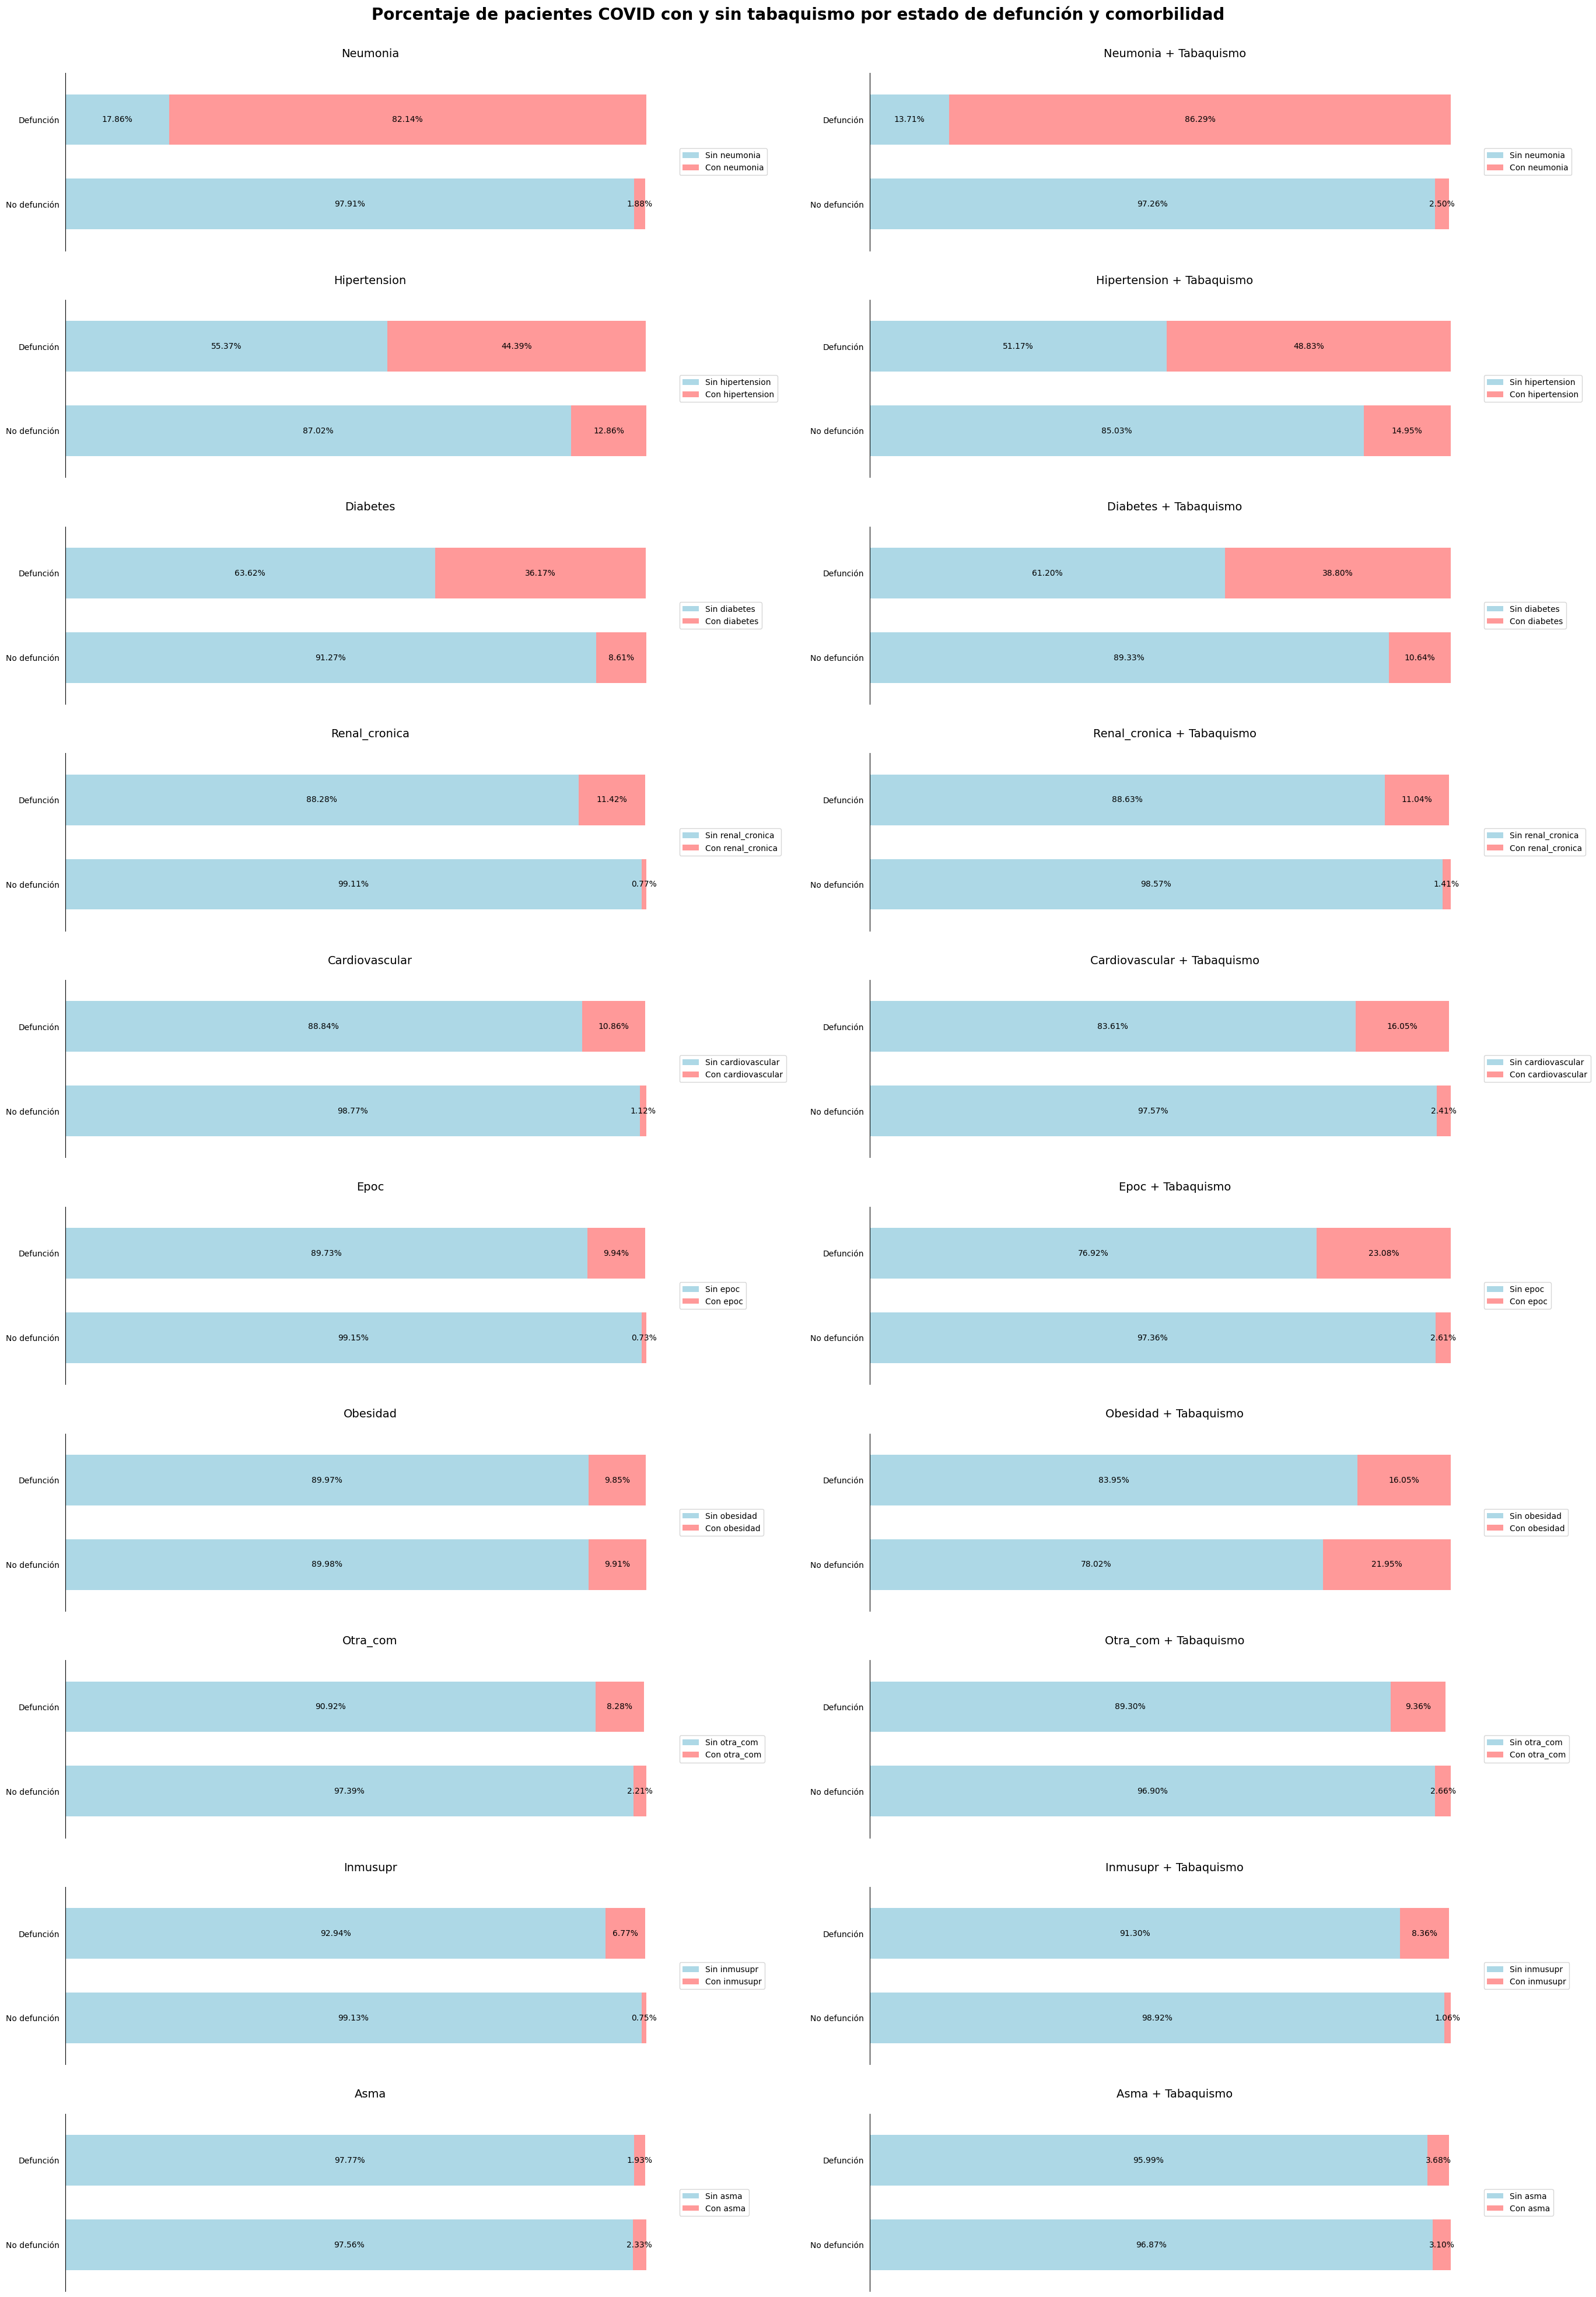

In [21]:
# Calcular los valores de defunción con comorbilidad para ordenar
defuncion_con_valores = {}
for var in COMORBILIDADES:
    prop_fall_con = len(df_covid[(df_covid['DEFUNCION'] == 1) & (df_covid[var] == 1)]) / N_COVID_FALLECIDOS
    defuncion_con_valores[var] = prop_fall_con

# Ordenar las variables en base a los valores calculados
variables_ordenadas = sorted(defuncion_con_valores, key=defuncion_con_valores.get, reverse=True)

# Crear figura y subgráficas
fig, axs = plt.subplots(nrows=len(COMORBILIDADES), ncols=2, figsize=(28, 4 * len(COMORBILIDADES)))
fig.suptitle('Porcentaje de pacientes COVID con y sin tabaquismo por estado de defunción y comorbilidad', fontsize=20, fontweight="bold", y=0.99)

for i, var in enumerate(variables_ordenadas):
    # Gráficas generales
    prop_no_fall_con = len(df_covid[(df_covid['DEFUNCION'] == 2) & (df_covid[var] == 1)]) / N_COVID_NO_FALLECIDOS
    prop_no_fall_sin = len(df_covid[(df_covid['DEFUNCION'] == 2) & (df_covid[var] == 2)]) / N_COVID_NO_FALLECIDOS

    prop_fall_con = len(df_covid[(df_covid['DEFUNCION'] == 1) & (df_covid[var] == 1)]) / N_COVID_FALLECIDOS
    prop_fall_sin = len(df_covid[(df_covid['DEFUNCION'] == 1) & (df_covid[var] == 2)]) / N_COVID_FALLECIDOS

    data = {
        'Estado': ['No defunción', 'Defunción'],
        f'Sin {var.lower()}': [prop_no_fall_sin, prop_fall_sin],
        f'Con {var.lower()}': [prop_no_fall_con, prop_fall_con]
    }

    df_plot = pd.DataFrame(data)

    df_plot.set_index('Estado').plot(kind='barh', stacked=True, color=['#add8e6', '#ff9999'], width=0.6, ax=axs[i, 0])
    axs[i, 0].set_xlabel('')
    axs[i, 0].set_ylabel('')
    axs[i, 0].set_title(var.capitalize(), pad=20, fontsize=14)
    axs[i, 0].legend(labels=[f'Sin {var.lower()}', f'Con {var.lower()}'], title='', loc='center left', bbox_to_anchor=(1, 0.5))

    for j, (sin_var, con_var) in enumerate(zip(df_plot[f'Sin {var.lower()}'], df_plot[f'Con {var.lower()}'])):
        axs[i, 0].text(sin_var / 2, j, f'{sin_var:.2%}', ha='center', va='center', color='black')
        axs[i, 0].text(sin_var + con_var / 2, j, f'{con_var:.2%}', ha='center', va='center', color='black')

    axs[i, 0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    axs[i, 0].tick_params(axis='y', which='both', left=False)
    axs[i, 0].spines['left'].set_visible(True)
    axs[i, 0].spines['bottom'].set_visible(False)
    axs[i, 0].spines['top'].set_visible(False)
    axs[i, 0].spines['right'].set_visible(False)

    # Gráficas con filtro de tabaquismo
    df_covid_tabaquismo = df_covid[df_covid['TABAQUISMO'] == 1]
    total_no_fallecidos_tabaquismo = len(df_covid_tabaquismo[df_covid_tabaquismo['DEFUNCION'] == 2])
    total_fallecidos_tabaquismo = len(df_covid_tabaquismo[df_covid_tabaquismo['DEFUNCION'] == 1])

    prop_no_fall_con_tabaquismo = len(df_covid_tabaquismo[(df_covid_tabaquismo['DEFUNCION'] == 2) & (df_covid_tabaquismo[var] == 1)]) / total_no_fallecidos_tabaquismo
    prop_no_fall_sin_tabaquismo = len(df_covid_tabaquismo[(df_covid_tabaquismo['DEFUNCION'] == 2) & (df_covid_tabaquismo[var] == 2)]) / total_no_fallecidos_tabaquismo

    prop_fall_con_tabaquismo = len(df_covid_tabaquismo[(df_covid_tabaquismo['DEFUNCION'] == 1) & (df_covid_tabaquismo[var] == 1)]) / total_fallecidos_tabaquismo
    prop_fall_sin_tabaquismo = len(df_covid_tabaquismo[(df_covid_tabaquismo['DEFUNCION'] == 1) & (df_covid_tabaquismo[var] == 2)]) / total_fallecidos_tabaquismo

    data_tabaquismo = {
        'Estado': ['No defunción', 'Defunción'],
        f'Sin {var.lower()}': [prop_no_fall_sin_tabaquismo, prop_fall_sin_tabaquismo],
        f'Con {var.lower()}': [prop_no_fall_con_tabaquismo, prop_fall_con_tabaquismo]
    }

    df_plot_tabaquismo = pd.DataFrame(data_tabaquismo)

    df_plot_tabaquismo.set_index('Estado').plot(kind='barh', stacked=True, color=['#add8e6', '#ff9999'], width=0.6, ax=axs[i, 1])
    axs[i, 1].set_xlabel('')
    axs[i, 1].set_ylabel('')
    axs[i, 1].set_title(f'{var.capitalize()} + Tabaquismo', pad=20, fontsize=14)
    axs[i, 1].legend(labels=[f'Sin {var.lower()}', f'Con {var.lower()}'], title='', loc='center left', bbox_to_anchor=(1, 0.5))

    for j, (sin_var, con_var) in enumerate(zip(df_plot_tabaquismo[f'Sin {var.lower()}'], df_plot_tabaquismo[f'Con {var.lower()}'])):
        axs[i, 1].text(sin_var / 2, j, f'{sin_var:.2%}', ha='center', va='center', color='black')
        axs[i, 1].text(sin_var + con_var / 2, j, f'{con_var:.2%}', ha='center', va='center', color='black')

    axs[i, 1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    axs[i, 1].tick_params(axis='y', which='both', left=False)
    axs[i, 1].spines['left'].set_visible(True)
    axs[i, 1].spines['bottom'].set_visible(False)
    axs[i, 1].spines['top'].set_visible(False)
    axs[i, 1].spines['right'].set_visible(False)

plt.tight_layout(pad=3.0)
plt.show()

### Responder a preguntas con base en nuestra variable objetivo DEFUNCIÓN

Se podría decir que el proyecto trata de cómo influyen distintas variables en las probabilidad de DEFUNCIÓN de pacientes diagnósticados con COVID. Esto lo aclaro para que, a la hora de evaluar la variable DEFUNCION, se utilice como primer filtro la variable CLASIFICACION_FINAL.

Vicios y comorbilidades:

Comorbilidades, TABAQUISMO, CLASIFICACION_FINAL, DEFUNCION 

Se podría hacer una matriz de correlación de estas variables

¿De los pacientes COVID positivos con tabaquismo, qué proporción falleció? 

¿De los pacientes COVID positivos que fallecieron y no fallecieron, qué proporción tenía por lo menos otro padecimiento (comorbilidad)? 

¿De los pacientes COVID positivos que fallecieron y no fallecieron, qué comorbilidad se presentó en mayor proporción de casos?

¿De los pacientes COVID positivos que fueron intubados, qué proporción falleció?


Demografía: 

¿Cómo influye el sexo en la proporción de casos COVID positivos? 

¿Cómo influye el sexo en la proporción de fallecimientos?

¿Cómo influye ser indígena o hablar lengua indígena en la proporción de casos COVID positivos?

¿Cómo influye ser indígena o hablar lengua indígena en la proporción de fallecimientos?

Aspectos geográficos: 

¿Qué entidades han tenido mayor proporción de casos COVID? 

¿Qué entidades han tenido mayor proporción de fallecimientos? 

¿Las entidades coinciden? En caso de que no, ¿porqué podrían fallecer más en entidades que no necesariamente presentan la mayor cantidad de casos?

Se puede ahondar en este análisis repitiendo las preguntas pero a nivel municipio. 